#### 단어표현(Word Representation) 방법 분류 참고 사이트
https://heytech.tistory.com/335
* * *

### 워드임베딩(Word Embedding)
단어(Word)를 컴퓨터가 이해할 수 있도록 벡터로 표현하는 기법 중 하나로, 밀집표현(Dense Representation) 방식을 통해 표현하는 기법을 말한다. 이때, 밀집표현과 반대되는 개념이 희소표현(Sparse Representation)이다.

워드임베딩 방법론으로는 LSA, Word2Vec, Glove, FastText, ELMO 등이 있다.

- 희소표현(Sparse Representation) : 수치화하여 표현할 때 극히 일부의 인덱스만 특정 값으로 표현하고, 대부분의 나머지 인덱스는 의미 없는 값으로 표현하는 기법이다. 대표적으로 원-핫 인코딩(One-Hot Encoding) 방식이 있다.

```
tip> 카운트 기반의 단어 표현기법 중 하나인 단어문서행렬(Document Term Matrix, DTM) 역시 희소표현을 사용한다. 원핫인코딩과 카운트 기반 단어 표현기법은 단어의 의미는 고려하지 않고 단순히 어떤 단어가 문서에서 몇 번 등장했는지만 고려하기 때문에 단어의 의미를 반영하지 못한다.
```

- 밀집표현(Dense Representation) : 텍스트를 실수값으로 구성하여 사용자가 설정한 차원의 벡터로 표현한다. 
* * *

### 1. Word2Vec
#### 1) Continuous Bag of Words(CBOW)
Word2Vec는 학습방식에 따라 크게 2가지로 나눌 수 있습니다. CBOW는 주변 단어(Context Word)로 중간에 있는 단어를 예측하는 방법입니다. 여기서 중간에 있는 단어를 중심 단어(Center Word) 또는 타겟 단어(Target Word)라고 부른다. 

- 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [31]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
train_data = pd.read_table('ratings.txt')
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [32]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [33]:
print(train_data.isnull().values.any()) # 결측값 유무 확인

True


In [34]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [35]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [36]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

C:\Users\heo\AppData\Local\Temp\ipykernel_12656\1778287312.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [38]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

from tqdm import tqdm
tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [07:22<00:00, 452.08it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


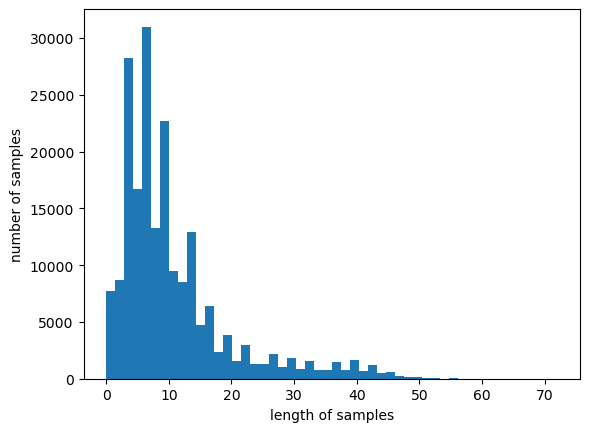

In [39]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [41]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

# result: tokenized_data
# size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
# window = 컨텍스트 윈도우 크기
# min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
# workers = 학습을 위한 프로세스 수
# sg = 0은 CBOW, 1은 Skip-gram.

In [42]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [43]:
# '히어로'와 유사한 단어 조회
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8559787273406982), ('호러', 0.8458625078201294), ('무협', 0.8378803730010986), ('물의', 0.8313953876495361), ('정통', 0.8245922923088074), ('느와르', 0.8238562345504761), ('무비', 0.8140727281570435), ('블록버스터', 0.8045874834060669), ('물', 0.7999942898750305), ('블랙', 0.7888810038566589)]


#### 2) Skip-gram
중심 단어를 바탕으로 주변 단어들을 예측하는 방법이다.

- 영어 Word2Vec 만들기

In [3]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x1e1f7f15b70>)

In [5]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [6]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [7]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [42]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=10, min_count=100, workers=4, sg=0)

In [12]:
model_result = model.wv.most_similar("solution")
print(model_result)

[('problem', 0.6614372730255127), ('model', 0.5888693928718567), ('challenge', 0.57535719871521), ('strategy', 0.5438941717147827), ('alternative', 0.5418916940689087), ('issue', 0.5305991172790527), ('mechanism', 0.5227100849151611), ('tool', 0.5163832306861877), ('component', 0.5068934559822083), ('product', 0.5043728351593018)]


In [25]:
model.wv['solution']

array([ 0.5162569 ,  1.1854112 , -0.540489  , -0.3174908 , -0.67301613,
        1.2896131 ,  0.4866755 ,  0.70087063, -0.10246723,  1.5981007 ,
       -1.2282852 , -0.26331323,  0.89234805,  0.15287279, -1.0656525 ,
       -0.20825604,  1.2145147 ,  0.36993405,  0.39668643,  0.00760886,
       -0.5297839 , -0.64906436,  0.36039326,  0.09888655,  0.62371176,
       -0.7849785 ,  0.23773843,  0.77092004,  0.07282821,  0.5093171 ,
       -0.4177361 , -0.7621471 ,  0.19389307, -0.48915926, -0.3483906 ,
       -1.0752548 ,  0.20582417,  0.9791798 ,  1.8442515 ,  0.6901101 ,
       -1.1146265 , -0.115698  ,  1.2145609 , -0.36396945, -1.4480692 ,
       -0.2660444 , -0.73750216,  1.1859194 , -1.2747749 , -0.12609805,
        0.41301888,  0.5300677 , -0.72956586, -1.1980388 ,  0.40854087,
        0.49249846, -0.87264436,  0.9075838 ,  0.10748278,  0.48147893,
        1.1524001 , -0.53778076,  0.349974  ,  1.2052904 , -1.3721718 ,
        0.49870142,  0.37576774, -0.13645048, -0.3197939 ,  0.49

In [ ]:
# model.wv.save_word2vec_format('eng_w2v') # 모델 저장
# loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

#### 시각화

In [57]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# pip install gensim==3.8.1

In [83]:
model = Word2Vec(sentences=result, vector_size=100, window=10, min_count=500, workers=4, sg=0)

In [84]:
labels = [i for i in model.wv.key_to_index]
tokens = model.wv[labels]
tsne_model = TSNE(init='pca',learning_rate='auto')
new_values = tsne_model.fit_transform(tokens)

C:\ProgramData\Anaconda3\envs\intown\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


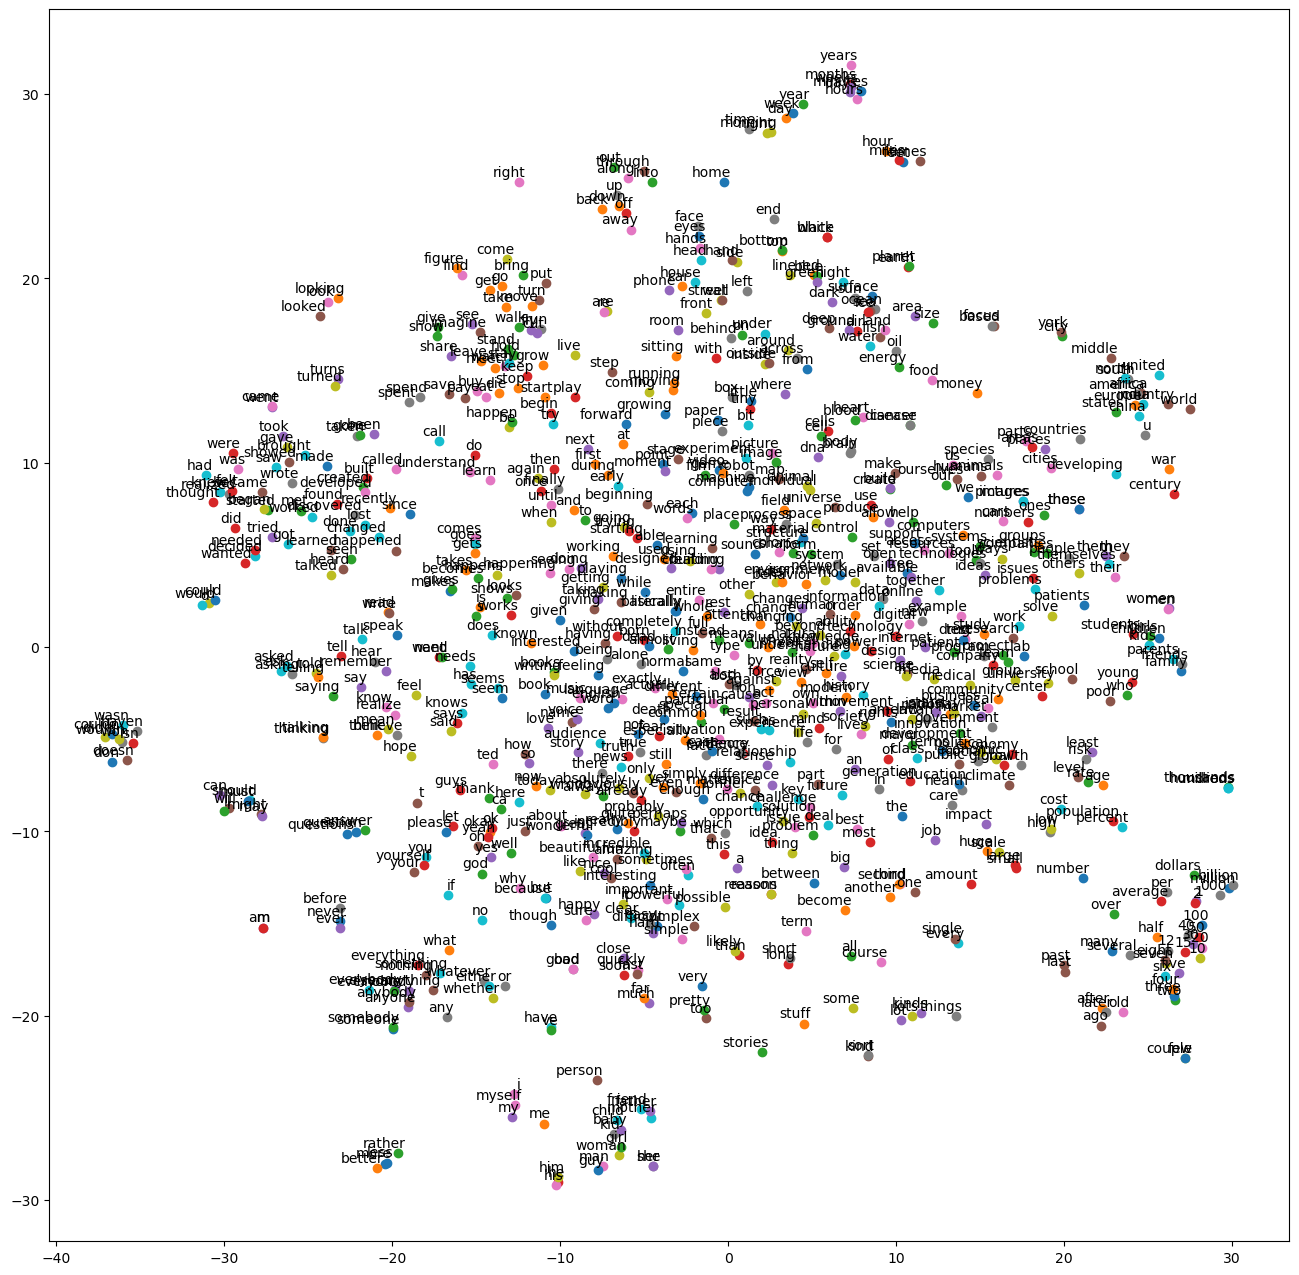

In [86]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(new_values.shape[0]):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

In [91]:
# solution에 대해 가장 유사한 단어 5개 추출
most_sim_words = [i[0] for i in model.wv.most_similar(positive='solution', topn=5)]
most_sim_words.append('solution')
most_sim_words

['problem', 'model', 'challenge', 'issue', 'solve', 'solution']

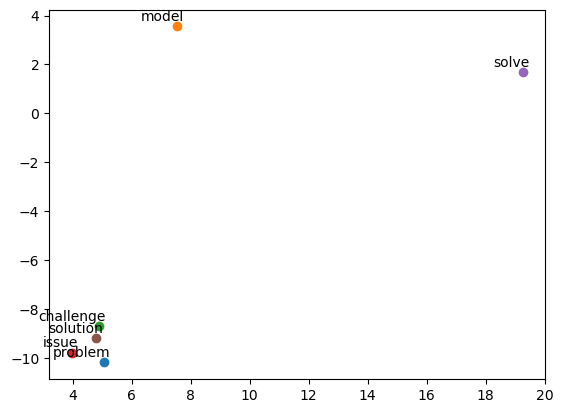

In [90]:
for word in most_sim_words:
    i = labels.index(word)
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

- - -

In [77]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\ProgramData\Anaconda3\envs\intown\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\ProgramData\Anaconda3\envs\intown\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


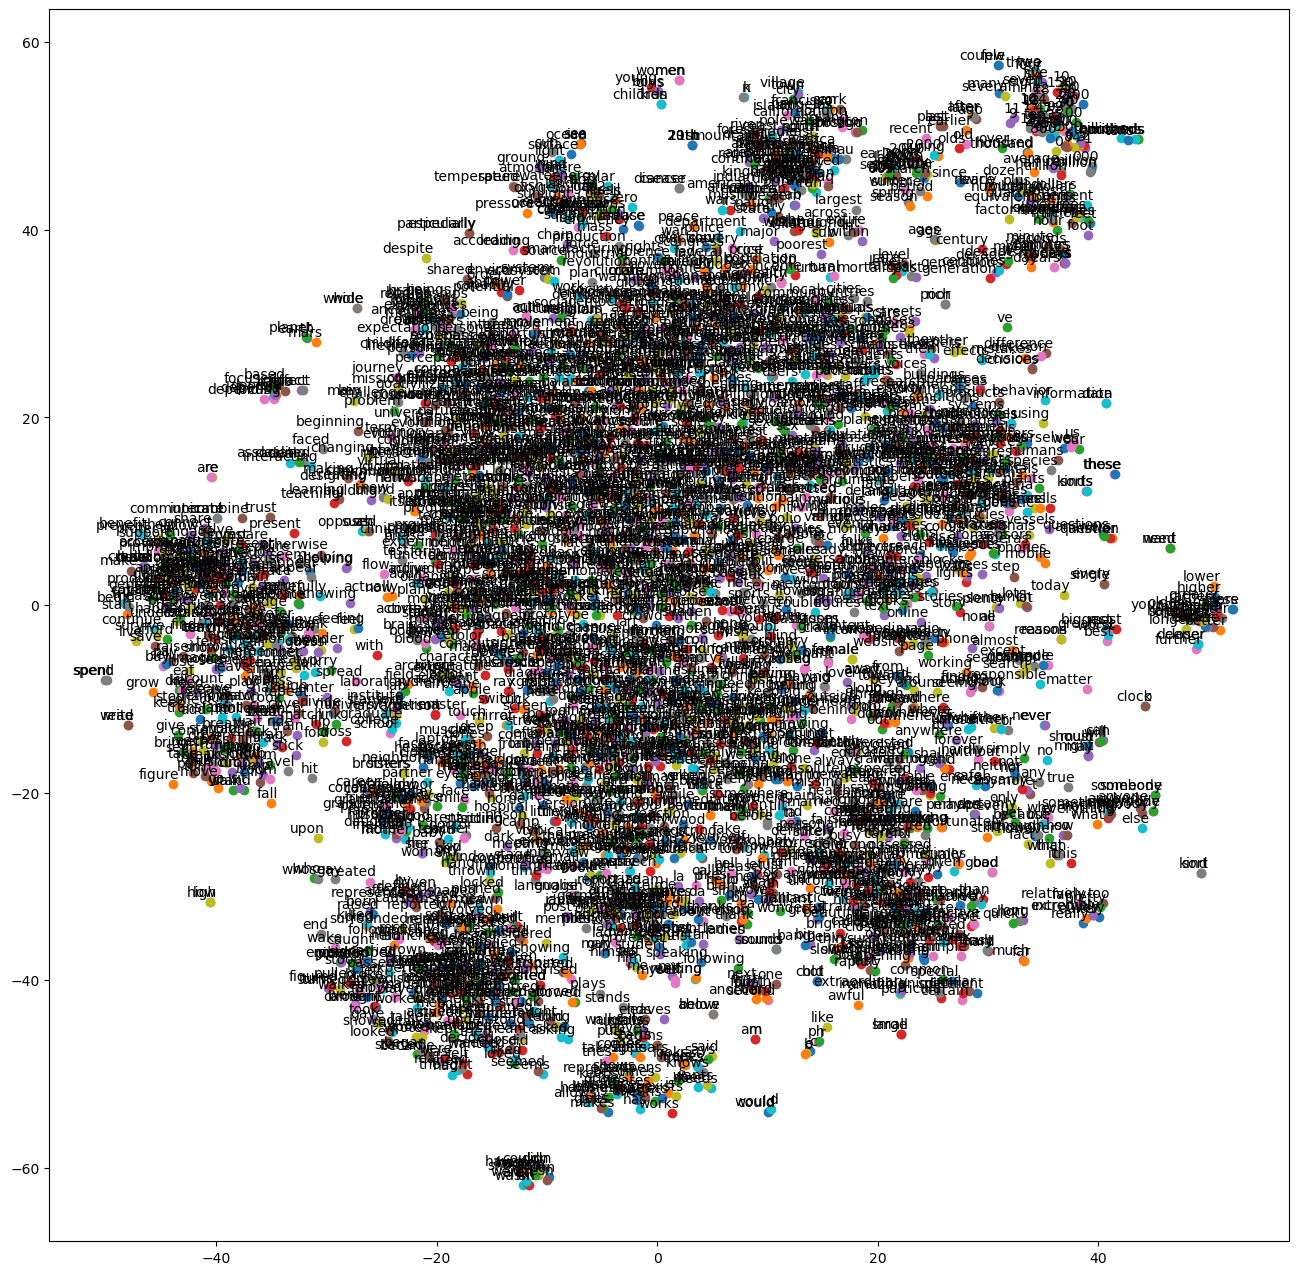

In [78]:
tsne_plot(model)

In [81]:
model2 = Word2Vec(sentences=result, vector_size=100, window=10, min_count=500, workers=4, sg=0)

C:\ProgramData\Anaconda3\envs\intown\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\ProgramData\Anaconda3\envs\intown\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


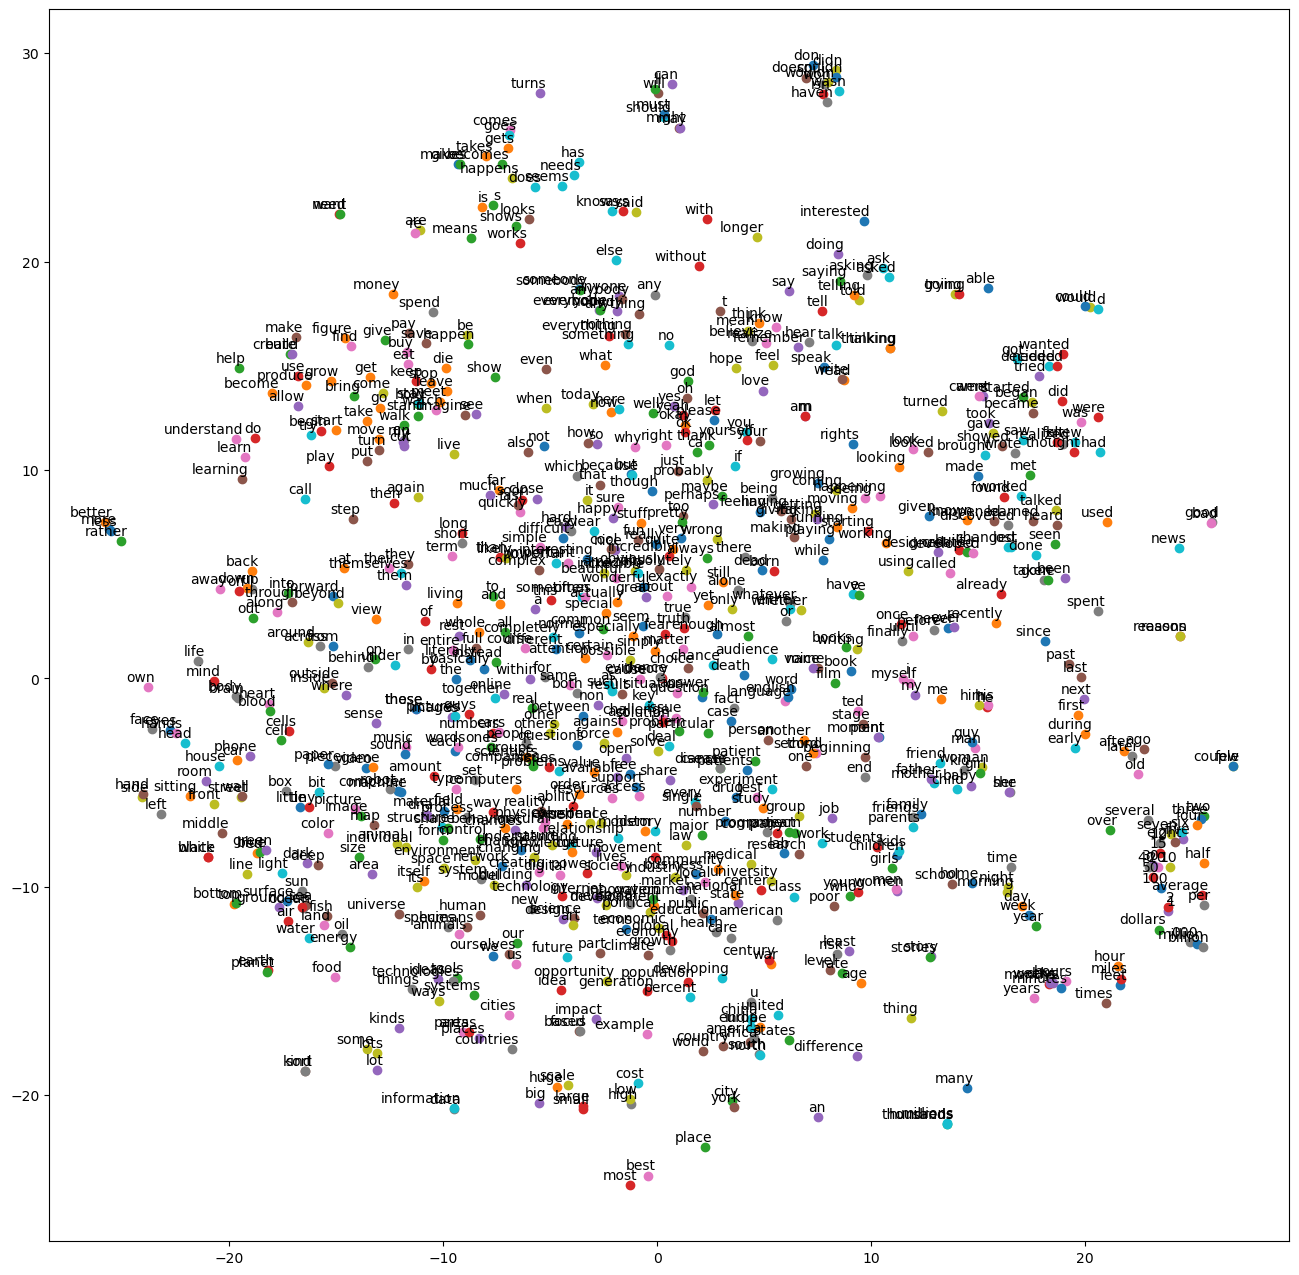

In [82]:
tsne_plot(model2)

참고자료 : https://habr.com/en/companies/vk/articles/449984/
https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook
https://stackoverflow.com/questions/70268270/how-to-plot-tsne-on-word2vec-created-from-gensim-for-the-most-similar-20-cases